In [96]:
import pandas as pd
import numpy as np

df = pd.read_json('../data/raw/full_property.json')

In [97]:
# take a look at the size of the data
df.shape

(12, 11206)

In [98]:
# there are 12 rows in the data, but we have 12 features,
# so data needs to have 12 columns instead -- need to transpose this data

df = df.transpose()
df.head()

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/unit-503-466-swanston-street-carlton-vic-3053-16066115,unit 503/466 Swanston Street Carlton VIC 3053,$320,"[-37.8059838, 144.9632701]",1,1,0,Apartment / Unit / Flat,Fully Furnished Studio Apartment in Swanston,"class=""css-dxogle"">* Unverified feature<svg a...","[Alarm System, Built in wardrobes, Intercom]",[],[]
https://www.domain.com.au/61-rowans-road-highett-vic-3190-16080336,61 Rowans Road Highett VIC 3190,$460.00,"[-37.9475765, 145.0509956]",3,1,1,House,Quaint three bedroom in a great location!,"class=""css-dxogle"">* Unverified feature<svg a...","[Split System Air Con, Split System Heating, E...",NaN,[]
https://www.domain.com.au/29-caspian-circuit-point-cook-vic-3030-16023583,29 Caspian Circuit Point Cook VIC 3030,$430.00 per week,"[-37.9002294, 144.7452156]",3,2,2,House,Life at Your Fingertips,"class=""css-dxogle"">* Unverified feature<svg a...",[],NaN,[]
https://www.domain.com.au/36-bradleys-lane-north-warrandyte-vic-3113-16038589,36 Bradleys Lane North Warrandyte VIC 3113,$720 per week,"[-37.7370336, 145.2124356]",4,3,3,House,Bradleys Lane,"class=""css-dxogle"">* Unverified feature<svg a...",[],NaN,[]
https://www.domain.com.au/12-isaac-road-keysborough-vic-3173-16020786,12 Isaac Road Keysborough VIC 3173,$515 pw,"[-37.9840266, 145.1782469]",3,3,1,House,LUXURY SUBURBAN LIVING,"class=""css-dxogle"">* Unverified feature<svg a...","[Built in wardrobes, Dishwasher]",NaN,[]


In [99]:
type(df["coordinates"][0])

list

### 1: Cost

In [100]:
# the cost of a real estate property is in dollars per week.
# I will transform all the values in the cost_text column into integers.

df2 = df.copy()
import re


# the list of instances where the values are ambiguous or invalid,
# each instance will be in the form of (index, string)
ambiguous = dict()

for i in range(df2.shape[0]):
    cost = re.findall(r"[\d,]+", df2.iat[i, 1])

    if len(cost) == 0:
        df2.iat[i, 1] = np.nan
    
    else:
        # find the element with length 3, since it's the most likely one
        cost2 = [i for i in cost if len(i) == 3]

        if len(cost2) == 1:
            # if there's only one, then it's very likely that it's the correct price we want
            df2.iat[i, 1] = int(cost2[0])

        else:
            # otherwise, this is where things get wacky
            string = df2.iat[i, 1]
        
            # if there is no mention, assume the price is per week
            # there will be outliers, but they can be detected and removed afterwards.

            # if only monthly or yearly price is listed, simply get the estimate by dividing 4 or 52.
            week = ["/w", "pw", "PW", "Week", "week"]
            month = ["pcm", "PCM", "pm", "PM", "mth", "month", "Month", "MONTH"]
            annual = ["p.a", "pa", "Annually"]

            # none of month or annual price is listed, so the listed price is likely to be per week
            if not any(sub_month in string for sub_month in month) and \
                not any(sub_annual in string for sub_annual in annual):
                # dealing with N,NNN.NN format
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")
                else:
                    # the only other alternative to this is to clean it manually.
                    # However, we actually end up with 59 values left *in total*,
                    # and doing so manually is going to be extremely tedious. Therefore, I opt
                    # to sacrifice the tedious-ness with a slightly higher chance of picking
                    # up false positives (i.e., picking up values that shouldn't be picked up)
                    # by taking cost[0] as the true rent price.
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))

                    # you can see the cost_text string by looking at this dict value
                    ambiguous[i] = string

            # weekly price is listed
            elif any(sub_week in string for sub_week in week):
                # dealing with N,NNN.NN format
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")
                else:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                    ambiguous[i] = string

            # only monthly price is listed
            elif any(sub_month in string for sub_month in month) and \
                not any(sub_week in string for sub_week in week) and \
                not any(sub_annual in string for sub_annual in annual):
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) / 4
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = (int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")) / 4
                else:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                    ambiguous[i] = string

            # only annual price price is listed
            elif not any(sub_month in string for sub_month in month) and \
                not any(sub_week in string for sub_week in week) and \
                any(sub_annual in string for sub_annual in annual):
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) / 52
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = (int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")) / 52
                else:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                    ambiguous[i] = string

            else:
                df2.iat[i, 1] = int(cost[0].replace(",", ""))
                ambiguous[i] = string

ambiguous


{954: '$1099pw - Stay 1 mth+',
 1045: '$1190pw Stay 1 mth',
 1166: '$1050pw Stay 1 mth',
 1723: '$1100 PW / $4780 PCM',
 1975: '$1029pw - Stay 1 mth+',
 2093: '$325 Per Week Until April 2022. Increase to $335 Per Week a',
 2293: '$220.00 pw- (rent increase to $285 pw from 25/1/23',
 2414: '$195 per week - Then $245 per week from 10/02/2023',
 2544: 'APPLY NOW - Studio From $250/w & 2 Bed From $385/w',
 2554: '$3,000 per month, plus GST & Outgoings',
 2751: '$560pw/$2.433pcm',
 2758: '$185 Per Week - $195pw from 03/02/2023',
 2868: '$240 pw until 20/01/2023 then increase to $320pw',
 3178: '$1036pw - Stay 1 mth+',
 3357: '$750 per week 750',
 3425: '$1015pw - Stay 1 mth+',
 3478: '$950pw/$4.128pcm',
 3817: '$480 per week 480.00',
 3845: '$750 to $775',
 4087: '$260 to $280',
 4137: '$2300pw / $9994pcm',
 4207: 'From $155 - $285 pw (bills included)',
 5045: '$1246pw - Stay 1 mth+',
 5460: '($1,350 pcm + $2,150 pcm)',
 5826: '$1800pw / $7821pcm',
 6079: '$1200pw - Stay 1 mth+',
 6090: '$1

In [113]:
### OUTLIER DETECTION/REMOVAL
import matplotlib.pyplot as plt

df = df2.copy()

df = df.dropna(subset=["cost_text"])
df = df.sort_values(by=["cost_text"])
df.head(8)

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/18-any-street-elwood-vic-3184-11296097,18 ANY Street Elwood VIC 3184,1.0,"[-37.8837091, 144.9896471]",2,1,1,New Apartments / Off the Plan,*** LANDLORDS WANTED ***,Do you own a property that you are currently l...,[],[],[]
https://www.domain.com.au/epping-vic-3076-14979037,Epping VIC 3076,2,"[-37.6341341, 145.016269]",4,2,2,House,No Deposit Required or Rent2own,"class=""css-dxogle"">* Unverified feature<svg a...","[Air conditioning, Bath, Built in wardrobes, M...",NaN,[]
https://www.domain.com.au/1102-70-lorimer-street-docklands-vic-3008-16019669,1102/70 Lorimer Street Docklands VIC 3008,2,"[-37.824812, 144.945973]",2,2,2,Apartment / Unit / Flat,Hidden Gem in the heart of Yarra's Edge,Welcome to 'Tower 3' in Mirvac's prestigious Y...,"[Ensuite, Dishwasher, Built in wardrobes, Gym,...",[],[]
https://www.domain.com.au/hayston-views-epping-vic-3076-13117775,Hayston Views Epping VIC 3076,2,"[-37.6290575, 145.0330526]",4,2,2,House,Rent2own Program - Home Will Be built To Satis...,Rent2own Building Grant Extended until March 2...,"[Air conditioning, Ensuite, Built in wardrobes...",[190],[552]
https://www.domain.com.au/point-cook-vic-3030-15692394,Point Cook VIC 3030,2,"[-37.9086372, 144.7522315]",4,2,2,House,Rent2own with No Deposit,First Step Homes has a solution for Homeowners...,"[Air conditioning, Bath, Built in wardrobes, M...",NaN,[]
https://www.domain.com.au/32-st-edmonds-rd-prahran-vic-3181-11971603,32 St Edmonds Rd Prahran VIC 3181,40,"[-37.8501194, 144.9920021]",1,1,0,Apartment / Unit / Flat,1x Secured Off Street Undercover Car Park avai...,PROPERTY ID: 7906 (quote when calling),"[Secure Parking, Rentbetter.com.au]",[],[]
https://www.domain.com.au/cp831-888-collins-street-docklands-vic-3008-16046909,CP831/888 Collins Street Docklands VIC 3008,50,"[-37.8207394, 144.9480769]",2,1,1,Apartment / Unit / Flat,"888 Collins Street, Docklands, VIC 3008- Car S...",. Secure indoor car space available for rent i...,[Secure Parking],[],[]
https://www.domain.com.au/cp1507-442-elizabeth-street-melbourne-vic-3000-15914317,CP1507/442 Elizabeth Street Melbourne VIC 3000,50,"[-37.8090217, 144.9608512]",0,1,0,Apartment / Unit / Flat,"442 Elizabeth Street, Melbourne, VIC 3000 - Ca...",. Secure indoor car space available for rent i...,[],[],[]


In [111]:
# well this one's easy, the first 5 values are very likely to be a false positive and thus they should be removed.
df = df.drop(df.index[:5])
df

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/32-st-edmonds-rd-prahran-vic-3181-11971603,32 St Edmonds Rd Prahran VIC 3181,40,"[-37.8501194, 144.9920021]",1,1,0,Apartment / Unit / Flat,1x Secured Off Street Undercover Car Park avai...,PROPERTY ID: 7906 (quote when calling),"[Secure Parking, Rentbetter.com.au]",[],[]
https://www.domain.com.au/cp831-888-collins-street-docklands-vic-3008-16046909,CP831/888 Collins Street Docklands VIC 3008,50,"[-37.8207394, 144.9480769]",2,1,1,Apartment / Unit / Flat,"888 Collins Street, Docklands, VIC 3008- Car S...",. Secure indoor car space available for rent i...,[Secure Parking],[],[]
https://www.domain.com.au/cp1507-442-elizabeth-street-melbourne-vic-3000-15914317,CP1507/442 Elizabeth Street Melbourne VIC 3000,50,"[-37.8090217, 144.9608512]",0,1,0,Apartment / Unit / Flat,"442 Elizabeth Street, Melbourne, VIC 3000 - Ca...",. Secure indoor car space available for rent i...,[],[],[]
https://www.domain.com.au/car-park-31-a-beckett-street-melbourne-vic-3000-13841674,Car Park 31 A'Beckett Street Melbourne VIC 3000,50,"[-37.809745, 144.958777]",2,1,0,House,Car Park for rent @ 31 A'Beckett Street Melbourne,"Car park for rent close to RMIT, Melbourne cen...",[],NaN,[]
https://www.domain.com.au/carpark-105-batman-street-west-melbourne-vic-3003-15775515,Carpark/105 Batman street West Melbourne VIC 3003,50,"[-37.810968, 144.9504968]",1,1,1,House,**Car Park Spaces Available For Lease @ Melbou...,"***CP 1702 (295)/393 Spencer Street, West Melb...",[],NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.domain.com.au/52-black-st-brighton-vic-3186-15410646,52 Black St Brighton VIC 3186,5500,"[-37.9159452, 144.9989003]",3,2,1,House,Fully Furnished - Brand New,"class=""css-dxogle"">* Unverified feature<svg a...",[],[294],[900]
https://www.domain.com.au/821-glen-huntly-road-caulfield-vic-3162-15845353,821 Glen Huntly Road Caulfield VIC 3162,38000,"[-37.886816, 145.0229097]",3,2,2,Semi-Detached,Business Opportunity Plus Residential Living I...,"class=""css-dxogle"">* Unverified feature<svg a...","[Air conditioning, Close to transport, Close t...",[184],[]
https://www.domain.com.au/148a-ferguson-street-williamstown-vic-3016-16024607,148A Ferguson Street Williamstown VIC 3016,39000,"[-37.85808370000001, 144.8926036]",3,1,1,Studio,OFFICE SPACE IN WILLIAMSTOWN,"Located in central Williamstown, this property...",[],NaN,[]
https://www.domain.com.au/110-beevers-street-footscray-vic-3011-14870244,110 Beevers Street Footscray VIC 3011,85000.0,"[-37.7958415, 144.9060052]",3,2,0,Apartment / Unit / Flat,Purpose Built Accommodation Home **INSPECTIONS...,Situated in central Footscray and within walki...,[],[],[]


In [115]:
# the last 4 values are also veeery unlikely or rather, almost impossible to actually happen.
df = df.sort_values(by=["cost_text"], ascending=False)
df = df.drop(df.index[:5])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5ac7a28670>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5ac7a28640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5ac7a28a60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5ac7a23a30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5ac7a236d0>],
 'means': []}

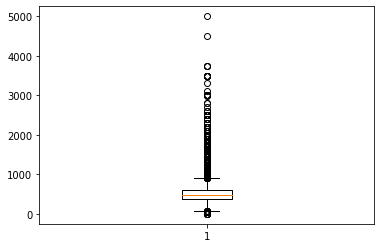

In [117]:
# now the clear outliers are removed, let's see how the data is distributed
cost_text = df["cost_text"].to_list()
plt.boxplot(cost_text)

In [126]:
# as seen on the graph there, the data looks very reasonable and there is no one obvious outlier that sticks out.
# (the top two can be argued, but, i'll leave it there for now)

### 2: Description head

In [119]:
# might need to install these libraries first
import enchant   
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocess_text(text):
    # preprocesses a string of texts :)
    
    # remove non-alphabetic characters
    text = re.sub(r'[^a-z\sA-Z]', ' ', text)
    # convert all spacing characters such as tabs and newlines to 
    # whitespace and ensure that only one whitespace character exists between each word
    text = re.sub(r'\s+', ' ', text)
    # Change all uppercase characters to lower case
    text = text.lower()
    # tokenise into words
    words = text.split()
    # remove invalid English words, stopwords, and single-letter words, and then stemming.
    # the valid word detector will unfortunately not be able to pick up words whose spelling 
    # are shortened (e.g., bedroom is written as bdrm), nor typos.
    d = enchant.Dict('en')
    ps = PorterStemmer()
    words = [ps.stem(i) for i in words \
        if (d.check(i) == True) and (len(i) > 1) and (i not in stopwords.words("english"))]
    return words

[nltk_data] Downloading package stopwords to /home/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
df3 = df.copy()

for i in range(df3.shape[0]):
    # just to see progress
    if (i % 2000) == 0:
        print(i)
        
    # text preprocessing
    words = preprocess_text(df3.iat[i, 7])
    sentence = ' '.join([i for i in words])
    df3.iat[i, 7] = sentence

0
2000
4000
6000
8000
10000


In [121]:
df3.head(3)

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/3502-14-16-the-esplanade-st-kilda-vic-3182-16002767,3502/14-16 The Esplanade St Kilda VIC 3182,5000,"[-37.8650177, 144.9746821]",1,1,1,Apartment / Unit / Flat,noth els compar,Inspired by the interplay of timeless design a...,"[INSIDE:, Gym, Intercom, Study, Floorboards, B...",[],[]
https://www.domain.com.au/4203-35-spring-street-melbourne-vic-3000-15939303,4203/35 Spring Street Melbourne VIC 3000,4500,"[-37.8141725, 144.9740049]",3,2,2,Apartment / Unit / Flat,arguabl captiv penthous,Possibly the most prestigious CBD address in t...,[],[],[]
https://www.domain.com.au/50-south-wharf-drive-docklands-vic-3008-16048359,50 South Wharf Drive Docklands VIC 3008,3750,"[-37.8223967, 144.938237]",2,2,1,Townhouse,luxuri style space,This spectacular five bedroom freehold waterfr...,"[Study, Alarm System, Balcony / Deck, Built in...",NaN,[]


NOTE: TF-IDF should be applied after the train test split during the modelling phase, not now? At least, that's what they do in machine learning last sem, I will hold off from doing this until I'm absolutely sure about this.

UPDATE: yes, it's ideally done after splitting

### Final 3 features (they're gonna be dropped) + coordinates

In [124]:
# change coordinates into two columns of latitude and longitude
df4 = pd.concat([pd.DataFrame(df3['coordinates'].to_list()), df3.reset_index()], axis=1)
df4.drop("coordinates", axis=1, inplace=True)
df4.rename(columns={0:'latitude', 1:"longitude"}, inplace=True)

# drop other columns that are not needed
# desc, additional_features, and areas are too scarce to be useful, 
# and areas are directly correlated to the number of bed/bath/park so they might be redundant anyway,
# desc_head should do the job enough.
df4.drop("desc", axis=1, inplace=True)
df4.drop("additional features", axis=1, inplace=True)
df4.drop("internal_area_sqkm", axis=1, inplace=True)
df4.drop("land_area_sqkm", axis=1, inplace=True)

df4.head()

,latitude,longitude,index,name,cost_text,Bed,Bath,Park,property_type,desc_head
0,-37.865018,144.974682,https://www.domain.com.au/3502-14-16-the-espla...,3502/14-16 The Esplanade St Kilda VIC 3182,5000,1,1,1,Apartment / Unit / Flat,noth els compar
1,-37.814172,144.974005,https://www.domain.com.au/4203-35-spring-stree...,4203/35 Spring Street Melbourne VIC 3000,4500,3,2,2,Apartment / Unit / Flat,arguabl captiv penthous
2,-37.822397,144.938237,https://www.domain.com.au/50-south-wharf-drive...,50 South Wharf Drive Docklands VIC 3008,3750,2,2,1,Townhouse,luxuri style space
3,-37.831081,145.052094,https://www.domain.com.au/hawthorn-east-vic-31...,Hawthorn East VIC 3123,3750,4,2,3,House,luxuri finest month leas avail unfurnish fulli...
4,-37.830116,144.956904,https://www.domain.com.au/901-902-85-market-st...,901 & 902/85 Market Street South Melbourne VIC...,3750.0,2,2,1,Apartment / Unit / Flat,call exclus penthous short stay minimum week stay


In [125]:
# save to csv
filename = "../data/raw/full_property_data.csv"
df4.to_csv(filename)